<a href="https://colab.research.google.com/github/fatday/My-Grad-Math-Works/blob/main/assignments/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2: Bayesian GLMs

In this assignment, you will develop Bayesian inference algorithms for (hierarchical) generalized linear models (GLMs). We'll put down football and focus on another timely subject: US presidential elections. We have downloaded data from the [MIT Election Data Science Lab](https://electionlab.mit.edu/data) consisting of presidential votes for each county in the US from 2000-2020 ${}^*$. We have also downloaded demographic covariates from 2018 for each county ${}^\dagger$. In this assignment, you will develop models to predict county-level votes given demographic data.

${}^*$ Unfortunately, the county-level results for 2024 are not yet available from the website above.

${}^\dagger$ Note that we could not find demographic data for Alaska, so unfortunately we will only work with the other 49 states and the District of Columbia.

## Setup

In [1]:
%%capture
!pip install jaxtyping
!pip install kaleido

In [2]:
import json
import torch
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

from fastprogress import progress_bar
from IPython.display import Image
from jaxtyping import Float, Int
from torch import Tensor
from torch.distributions import Binomial, Gamma, MultivariateNormal, kl_divergence
from urllib.request import urlopen

### Load the vote data

_Note: we did a little preprocessing of the raw data from the MIT Election Data Science Lab to extract counties that have both election and demographic data._

The vote data consists of votes per candidate for each county in the US for presidential elections from 2000 to 2020. Each county is identified by its [FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt). The FIPS code is a five digit integer representing the state and county within the state. We represent the FIPS code as a string since some codes start with zero.

**Note**: Broomfield County CO (FIPS code 08014) did not exist in 2000


In [3]:
votes = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/assignments/hw2/votes.csv")
votes.fips = votes.fips.apply(lambda x: str(int(x)).zfill(5))
votes

,year,state,state_po,county_name,fips,candidate,party,totalvotes,candidatevotes
0,2000,ALABAMA,AL,AUTAUGA,01001,AL GORE,DEMOCRAT,17208,4942
1,2000,ALABAMA,AL,AUTAUGA,01001,GEORGE W. BUSH,REPUBLICAN,17208,11993
2,2000,ALABAMA,AL,AUTAUGA,01001,OTHER,OTHER,17208,113
3,2000,ALABAMA,AL,AUTAUGA,01001,RALPH NADER,GREEN,17208,160
4,2000,ALABAMA,AL,BALDWIN,01003,AL GORE,DEMOCRAT,56480,13997
...,...,...,...,...,...,...,...,...,...
63206,2020,WYOMING,WY,WASHAKIE,56043,OTHER,OTHER,4032,71
63207,2020,WYOMING,WY,WESTON,56045,DONALD J TRUMP,REPUBLICAN,3560,3107
63208,2020,WYOMING,WY,WESTON,56045,JO JORGENSEN,LIBERTARIAN,3560,46
63209,2020,WYOMING,WY,WESTON,56045,JOSEPH R BIDEN JR,DEMOCRAT,3560,360


In [4]:
# Only Alaska is missing
votes["state"].unique()

array(['ALABAMA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO',
       'CONNECTICUT', 'DELAWARE', 'DISTRICT OF COLUMBIA', 'FLORIDA',
       'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA',
       'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND',
       'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI',
       'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE',
       'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON',
       'WEST VIRGINIA', 'WISCONSIN', 'WYOMING'], dtype=object)

### Load the demographic data

We also have county-level demographic data for all counties except those in Alaska. The data was collected in 2018. The fields of the table are described [here](https://github.com/MEDSL/2018-elections-unoffical/blob/master/election-context-2018.md). Note that each county has a matching FIPS code, again represented as a five digit string.

In [5]:
demo = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/assignments/hw2/demographics.csv")
demo.fips = demo.fips.apply(lambda x: str(int(x)).zfill(5))
demo

,state,county,trump16,clinton16,otherpres16,romney12,obama12,otherpres12,demsen16,repsen16,...,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc,fips
0,Alabama,Autauga,18172,5936,865,17379,6363,190,6331.0,18220.0,...,13.978456,53099.0,5.591657,12.417046,75.407229,10.002112,74.065601,42.002162,2.0,01001
1,Alabama,Baldwin,72883,18458,3874,66016,18424,898,19145.0,74021.0,...,18.714851,51365.0,6.286843,9.972418,70.452889,7.842227,68.405607,42.279099,3.0,01003
2,Alabama,Barbour,5454,4871,144,5550,5912,47,4777.0,5436.0,...,16.528895,33956.0,12.824738,26.235928,87.132213,19.579752,81.364746,67.789635,6.0,01005
3,Alabama,Bibb,6738,1874,207,6132,2202,86,2082.0,6612.0,...,14.885699,39776.0,7.146827,19.301587,88.000000,15.020490,87.471774,68.352607,1.0,01007
4,Alabama,Blount,22859,2156,573,20757,2970,279,2980.0,22169.0,...,17.192916,46212.0,5.953833,19.968585,86.950243,16.643368,86.163610,89.951502,1.0,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Wyoming,Sweetwater,12154,3231,1745,11428,4774,693,NaN,NaN,...,9.417120,68233.0,5.072255,9.314606,78.628507,6.238463,76.606813,10.916313,5.0,56037
3107,Wyoming,Teton,3921,7314,1392,4858,6213,393,NaN,NaN,...,11.837510,75594.0,2.123447,4.633570,46.211584,1.526877,41.769504,46.430920,7.0,56039
3108,Wyoming,Uinta,6154,1202,1114,6615,1628,296,NaN,NaN,...,10.678218,53323.0,6.390755,10.361224,81.793082,8.806312,81.080852,43.095937,7.0,56041
3109,Wyoming,Washakie,2911,532,371,3014,794,136,NaN,NaN,...,19.650341,46212.0,7.441860,12.577108,78.923920,10.299738,75.980688,35.954529,7.0,56043


In [6]:
demo.columns

Index(['state', 'county', 'trump16', 'clinton16', 'otherpres16', 'romney12',
       'obama12', 'otherpres12', 'demsen16', 'repsen16', 'othersen16',
       'demhouse16', 'rephouse16', 'otherhouse16', 'demgov16', 'repgov16',
       'othergov16', 'repgov14', 'demgov14', 'othergov14', 'total_population',
       'cvap', 'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'fips'],
      dtype='object')

### Helper function for plotting

We provide a simple function to plot values associated with each county.

In [7]:
with urlopen("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json") as response:
    geojson = json.load(response)

def plot_counties(fips, values, label="", cmap="RdBu", interactive=True):
    fig = px.choropleth(pd.DataFrame(dict(fips=fips, values=values)),
                        geojson=geojson,
                        locations="fips",
                        color="values",
                        color_continuous_scale=cmap,
                        scope="usa",
                        labels={"values":label})
    fig.update_layout(margin={"r":0, "t":0, "l":0, "b":0})
    if interactive:
        return fig
    else:
        return Image(fig.to_image(scale=2.0))

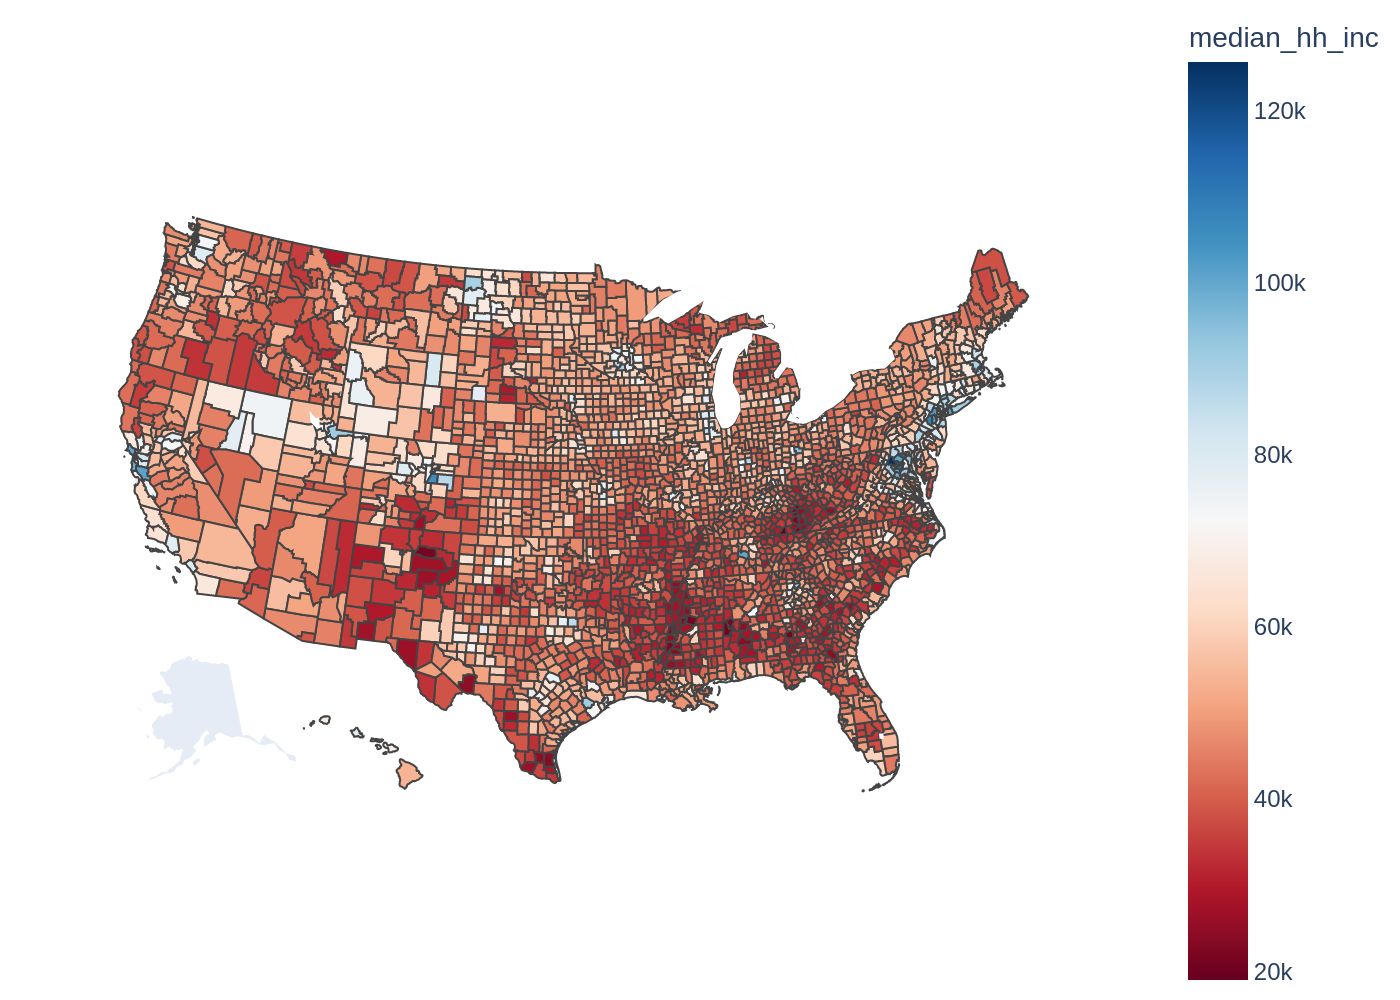

In [8]:
# Demo of how to plot.
# Note: you can use interactive plots in Colab. I turned off interactive mode
#   because the interactive plots don't render in the online book.
plot_counties(demo.fips,
              demo.median_hh_inc,
              label="median_hh_inc",
              cmap="RdBu",
              interactive=False)

## Part 0: Preprocessing

We have votes from $n=3111$ counties over six presidential elections in this dataset.

We will use the following covariates:
- `white_pct`
- `black_pct`
- `hispanic_pct`
- `foreignborn_pct`
- `female_pct`
- `age29andunder_pct`
- `age65andolder_pct`
- `median_hh_inc`
- `clf_unemploy_pct`
- `lesshs_pct`
- `lesscollege_pct`
- `lesshs_whites_pct`
- `lesscollege_whites_pct`
- `rural_pct`
- `ruralurban_cc`

The functions below extract pandas DataFrames for thse covariates and responses. They are given for you.


**Notes:**
- We include a bias term, $x_{i,1} = 1$ for all $i=1,\ldots,n$, in order to allow for an intercept.
- We ensure real-valued covariates are standardized to be mean-zero, unit standard deviation across counties.
- We use a one-hot encoding for categorical covariates, omitting the first category. For example, if a covariate $X$ takes on discrete values $\{1, \ldots, C\}$, encode it as a vector $v$ of length $C-1$ where $v_j = \mathbb{I}[X=j+1]$.



In [9]:
def preprocess_covariates(demo):
    """
    Preprocess the demographic data to extract the covariates for the regression,
    as described above.
    """
    # Sort the demographic data by FIPS code
    demo = demo.sort_values("fips")

    # Extract the scalar features and standardize them
    scalar_feat_names = ["white_pct",
                        "black_pct",
                        "hispanic_pct",
                        "foreignborn_pct",
                        "female_pct",
                        "age29andunder_pct",
                        "age65andolder_pct",
                        "median_hh_inc",
                        "clf_unemploy_pct",
                        "lesshs_pct",
                        "lesscollege_pct",
                        "lesshs_whites_pct",
                        "lesscollege_whites_pct",
                        "rural_pct"]

    X_scalar = demo[scalar_feat_names]
    X_scalar -= X_scalar.mean(axis=0)
    X_scalar /= X_scalar.std(axis=0)

    # Extract the categorical features and one-hot encode them
    cat_feat_names = ["ruralurban_cc"]
    X_cat = demo[cat_feat_names]
    X_cat = pd.get_dummies(X_cat, columns=cat_feat_names, drop_first=True)

    # Combine the features and add a bias term
    X = pd.concat([X_scalar, X_cat], axis=1)
    X.insert(0, "intercept", value=1.0)

    return X

covariates = preprocess_covariates(demo)

In [10]:
def extract_responses(votes, year):
    """
    Extract the responses for a given year from the votes dataframe.
    """
    # Extract the democratic and republican votes for the given year
    dem_votes = votes[(votes["party"] == "DEMOCRAT") & (votes["year"] == year)]
    rep_votes = votes[(votes["party"] == "REPUBLICAN") & (votes["year"] == year)]

    # Sort by fips codes
    dem_votes = dem_votes.sort_values("fips")
    rep_votes = rep_votes.sort_values("fips")
    assert (rep_votes.fips.values == dem_votes.fips.values).all()

    # Extract the states and code them as integers
    state_names = sorted(dem_votes.state.unique())
    s = pd.Categorical(dem_votes.state, categories=state_names).codes

    # Make a dataframe of responses
    responses = pd.DataFrame({
        "fips": dem_votes.fips.values,
        "state": dem_votes.state.values,
        "s": s,
        "y": dem_votes.candidatevotes.values,
        "N": dem_votes.candidatevotes.values + rep_votes.candidatevotes.values
        # "N": dem_votes.totalvotes.values
        })
    return responses, state_names

In [11]:
# Extract the responses for 2016
# Note: you may use this function
responses, state_names = extract_responses(votes, 2016)
responses

,fips,state,s,y,N
0,01001,ALABAMA,0,5936,24108
1,01003,ALABAMA,0,18458,91341
2,01005,ALABAMA,0,4871,10325
3,01007,ALABAMA,0,1874,8612
4,01009,ALABAMA,0,2156,25015
...,...,...,...,...,...
3106,56037,WYOMING,49,3231,15385
3107,56039,WYOMING,49,7314,11235
3108,56041,WYOMING,49,1202,7356
3109,56043,WYOMING,49,532,3443


In [12]:
# Check that the responses and demographic data are aligned
assert (responses.fips == demo.fips).all()

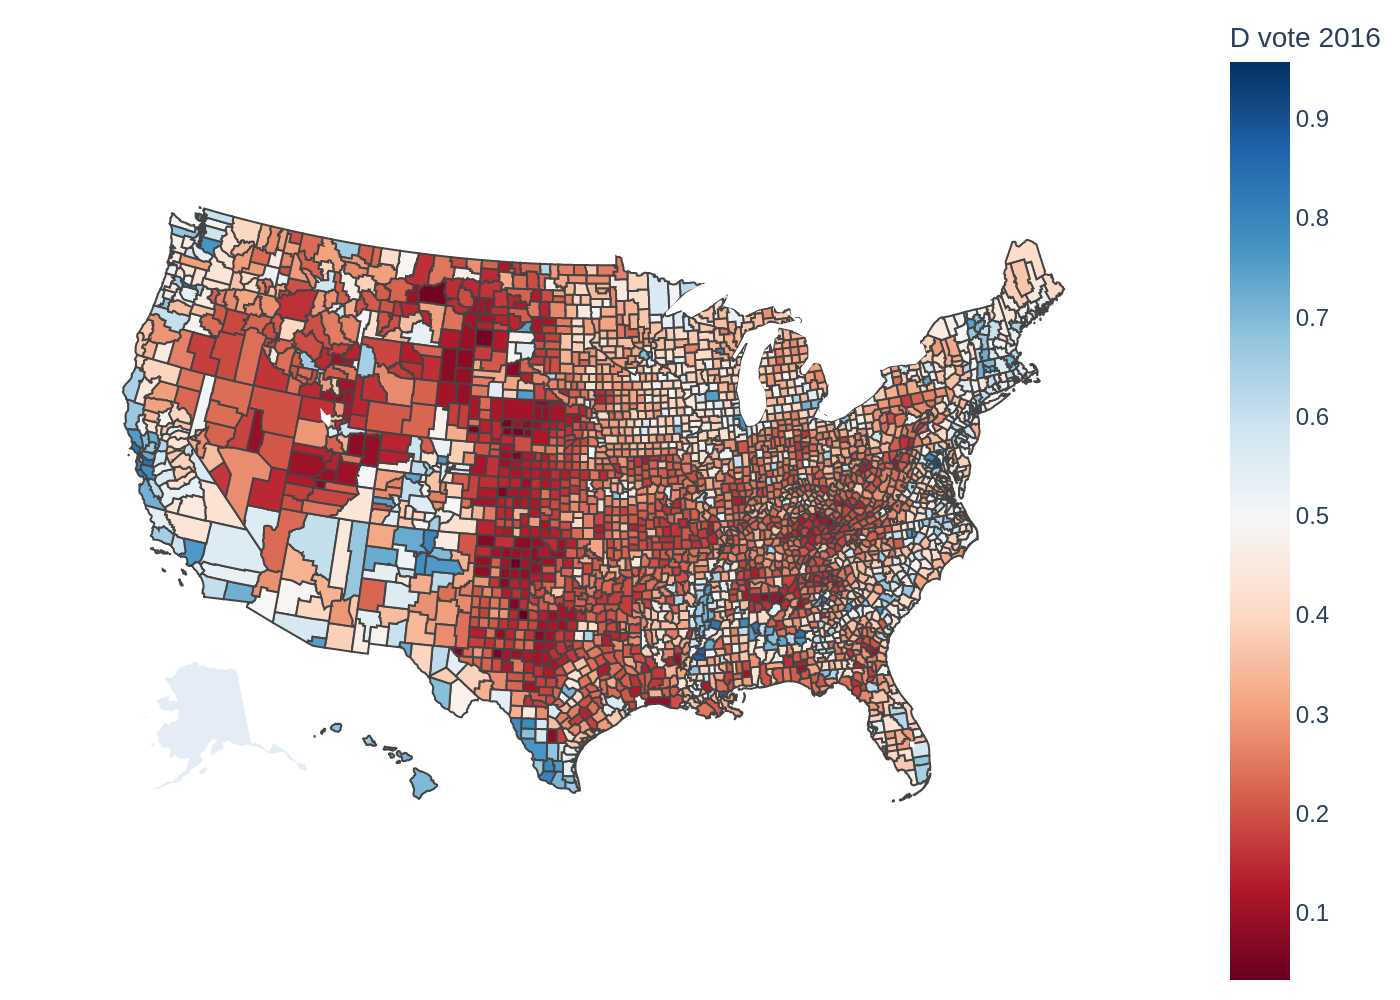

In [13]:
plot_counties(responses.fips,
              responses.y / responses.N,
              label="D vote 2016",
              interactive=False)

### Problem 0a: One-hot encodings

Explain why we omitted the first category in the encoding of categorical covariates.

If we consider the indicator $X$ variable for first category, and indicator $Y$ of the rest of the categories, notice that $Y=1-X$ then

\begin{align*}
Cov[X,Y]=E[XY]-E[X]E[Y]=&-E[X^2]+E[X]-E[X]-(E[X])^2=-Var[X]<0
\end{align*}

this will result a negative correlation for sure, so including the first category will introduce the prefect multicollinearity in the variables due to one-hot encoding, we need to omitt this to prevent perfect multicollinearity and reduces the number of parameters.

### Problem 0b: Other covariates

Explain why we didn't include `nonwhite_pct` in our set of covariates.

Let $X$ be random variable represent the `nonwhite_pct` and $Y$ be the sum of the rest of `_pct`, then we will get $Y=1-X$, which will result the same issuse (multicollinearity) as the last part of the problem, so we should not include it.

### Problem 0c: Interpreting the intercept

How does your answer to Problem 0b affect your interpretation of the intercept term?

When we exclude 'nonwhite_pct', then the intercpt will include the average outcome or effect for the 'nonwhite_pct' since it did not include as a covariate.

## Part 1: Bayesian Inference in a Binomial GLM via Polya-gamma augmentation

Let's start by modeling the results from election year 2016. You may choose to use the other years in Part 5, if you like.

Let
- $y_{i} \in \mathbb{N}$ denote the number of votes for the **Democratic Party candidate** in county $i=1,\ldots,n$ in **election year 2016**.
- $N_{i} \in \mathbb{N}$ denote the **total number of votes for the Democrat and Republican candidates** cast in county $i$ in **election year 2016**.  
- $s_i \in \{1,\ldots, S\}$ denote which state (including the District of Columbia) county $i$ belongs to, encoded as an integer. Remember that since Alaska is missing and DC is included, we only have $S=50$ unique values.
- $\mathbf{x}_i \in \mathbb{R}^p$ denote the vector of demographic covariates for county $i$, as extracted above.

### Model: Bayesian Binomial GLM

Start with a simple baseline model. Remember we're only modeling the data from 2016 right now. Fit a binomial GLM,
\begin{align*}
y_{i} &\sim \mathrm{Bin}(N_{i}, \, \sigma(\mathbf{x}_i^\top \boldsymbol{\beta}))
& \text{for } &i=1,\ldots,n\\
\boldsymbol{\beta} &\sim \mathrm{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
\end{align*}
where $\sigma$ is the logistic function, $\boldsymbol{\beta}$ are the weights, and $(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ are the prior mean and covariance.



### Algorithm: Gibbs sampling with Polya-gamma Augmentation
The Polya-gamma (PG) augmentation trick {cite:p}`polson2013bayesian` is based on the following identity,
\begin{align*}
\frac{(e^u)^y}{(1 + e^u)^N} = 2^{-N} e^{(y - \frac{N}{2}) u} \int e^{-\frac{1}{2} \omega u^2} \, \mathrm{PG}(\omega; N, 0) \, \mathrm{d} \omega,
\end{align*}
where $\mathrm{PG}(\omega; b, c)$ denotes the Polya-gamma density. The PG distribution has support on the non-negative reals, and it parameterized by a _shape_ $b \geq 0$ and a _tilt_ $c \in \mathbb{R}$.

The PG distribution isn't exactly textbook, but it has many nice properties. For instance, PG random variables are equal in distribution to a weighted sum of gamma random variables. If $\omega \sim \mathrm{PG}(b, c)$ then,
\begin{align*}
\omega \overset{d}{=} \frac{1}{2 \pi^2} \sum_{k=1}^\infty \frac{g_k}{(k - \tfrac{1}{2})^2 + \tfrac{c^2}{4 \pi^2}}
\end{align*}
where $g_k \overset{\mathrm{iid}}{\sim} \mathrm{Ga}(b, 1)$. Since the coefficients in this sum are decreasing with $k$, we can draw an approximate sample from a PG distribution by truncating the sum. Since the PG distribution doesn't exist in PyTorch, we have provided a helper function below to draw samples from the PG distribution.

**Notes:**
- As $b \to 0$, the PG density converges to a delta function at zero. This is useful when you have missing data.
- There are more efficient ways to sample PG random variables. See {cite:t}`windle2014sampling` and [https://github.com/slinderman/pypolyagamma](https://github.com/slinderman/pypolyagamma). The naive sampling code below should work for this assignment though.


In [ ]:
def sample_pg(b: Float[Tensor, "..."],
              c: Float[Tensor, "..."],
              trunc: int=200) -> \
              Float[Tensor, "..."]:
    """
    Sample X ~ PG(b, c) the naive way using a weighted sum of gammas.
    Note: there are much more efficient sampling methods. See

    Windle, Jesse, Nicholas G. Polson, and James G. Scott. "Sampling
        Pólya-gamma random variates: alternate and approximate techniques."
        arXiv preprint arXiv:1405.0506 (2014).
        https://arxiv.org/abs/1405.0506

    and https://github.com/slinderman/pypolyagamma

    Arguments
    ---------
    b: tensor of arbitrary shape specifying the "shape" argument of
        the PG distribution.

    c: tensor of arbitrary shape specifying the "tilt" argument of
        the PG distribution. Must broadcast with b.

    Returns
    -------
    tensor of independent draws of PG(b, c) matching the shapes of b and c.

    """
    # make sure the parameters are float tensors and broadcast compatible
    b = b if isinstance(b, torch.Tensor) else torch.tensor(b)
    c = c if isinstance(c, torch.Tensor) else torch.tensor(c)
    b = b.float()
    c = c.float()
    b, c = torch.broadcast_tensors(b, c)

    # Draw the PG random variates
    g = Gamma(b + 1e-8, 1.0).sample((trunc,))                          # (trunc, b.shape)
    g = torch.moveaxis(g, 0, -1)                                       # (b.shape, trunc)
    k = torch.arange(trunc) + 1
    w = 1 / ((k - 0.5)**2 + c[...,None]**2 / (4 * torch.pi**2))        # (c.shape, trunc)
    return 1 / (2 * torch.pi**2) * torch.sum(g * w, axis=-1)           # (b.shape,)

Text(0.5, 1.0, 'samples of PG(1,0) distribution')

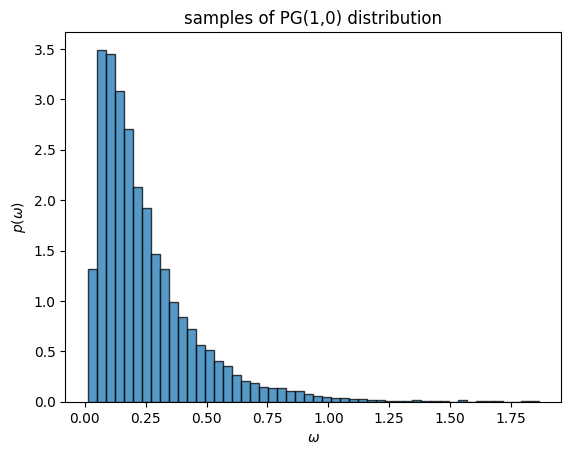

In [ ]:
omegas = sample_pg(torch.ones(10000), torch.zeros(10000))
_ = plt.hist(omegas, 50, density=True, alpha=0.75, edgecolor='k')
plt.xlabel(r"$\omega$")
plt.ylabel(r"$p(\omega)$")
plt.title("samples of PG(1,0) distribution")

### Problem 1a
Use the integral identity above to write the distribution $p(y, \beta \mid X)$ as a marginal of a distribution over an augmented space, $p(y, \beta, \omega \mid X)$.

_Your answer here_

### Problem 1b

The nice thing about this augmented distribution is that it has simple conditional distributions, which allows for a simple Gibbs sampling algorithm to approximate the posterior distribution.

Derive the conditional distribution, $p(\beta \mid y, X, \omega)$.

_Your answer here_

### Problem 1c

One nice property of the Polya-gamma distribution is that it is closed under exponential tilting,
\begin{align*}
e^{-\frac{1}{2} \omega c^2} \mathrm{PG}(\omega; b, 0) &\propto \mathrm{PG}(\omega; b, c).
\end{align*}
(Again, $\mathrm{PG}(\omega; b, c)$ denotes the Polya-gamma pdf.)

Derive the conditional distribution $p(\omega \mid y, X, \beta)$.

### Problem 1d

Implement a Gibbs sampling algorithm to sample the posterior distribution of the augmented model, $p(\beta, \omega \mid y, X)$. As described in the course notes, Gibbs sampling is a type of MCMC algorithm in which we iteratively draw samples from the conditional distributions. Here, the algorithm is,

> **Input:** Initial weights $\beta^{(0)}$, responses $y$, and covariates $X$.
>
> **For** iteration $m=1,\ldots, M$
> 1. Sample $\omega^{(m)} \sim p(\omega \mid \beta^{(m-1)}, y, X)$
> 2. Sample $\beta^{(m)} \sim p(\beta \mid y, X, \omega^{(m)})$
> 3. Compute log probability $\ell^{(m)} = \log p(y, \beta^{(m)} \mid X)$
>
> **Return** samples $\{\beta^{(m)}\}_{m=1}^M$ and log probabilities $\{\ell^{(m)}\}_{m=1}^M$.

Implement that algorithm by completing the code below.



In [ ]:
class BinomialGLM:
    """Implementation of a binomial GLM with PG augmentation.

    Let y = [y_1, ..., y_n] be a vector of responses,
    and X = [x_1, ..., x_n] be a matrix of covariates.

    The likelihood is given by,

        p(y | X, beta) = \prod_i Binomial(y_i | N_i, sigmoid(x_i^T beta))

    where N_i is the number of trials for the i-th and beta is the
    vector of regression coefficients. The prior on beta is a multivariate
    normal.
    """
    prior_mean: Float[Tensor, "num_features"]
    prior_cov: Float[Tensor, "num_features num_features"]

    def __init__(self,
                 prior_mean: Float[Tensor, "num_features"],
                 prior_cov: Float[Tensor, "num_features num_features"]) \
                 -> None:
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov

    def log_prob(self,
                 y: Float[Tensor, "num_datapoints"],
                 N: Float[Tensor, "num_datapoitns"],
                 X: Float[Tensor, "num_datapoints num_features"],
                 beta: Float[Tensor, "num_features"]) \
                 -> float:
        """
        Compute the log joint probability of the parameters and responses.
        """
        # TODO
        lp = ...
        return lp

    def _gibbs_update_beta(self,
                           y: Float[Tensor, "num_datapoints"],
                           N: Float[Tensor, "num_datapoints"],
                           X: Float[Tensor, "num_datapoints num_features"],
                           omegas: Float[Tensor, "num_datapoints"]) \
                           -> Float[Tensor, "num_features"]:
        """
        Sample the conditional distribution of beta
        """
        # TODO
        betas = ...
        return betas

    def _gibbs_update_omegas(self,
                             N: Float[Tensor, "num_datapoints"],
                             X: Float[Tensor, "num_datapoints num_features"],
                             betas: Float[Tensor, "num_features"]) \
                             -> Float[Tensor, "num_datapoints"]:
        """
        Sample the PG conditional.
        """
        # TODO
        omegas = ...
        return omegas

    def gibbs(self,
              y: Float[Tensor, "num_datapoints"],
              N: Float[Tensor, "num_datapoitns"],
              X: Float[Tensor, "num_datapoints num_features"],
              init_beta: Float[Tensor, "num_features"],
              num_iters: int) \
              -> Float[Tensor, "num_iters num_features"]:
        """
        Run a Gibbs sampler to sample from the posterior.
        """
        betas = init_beta
        lp = self.log_prob(y, N, X, betas)
        samples = [dict(betas=betas, lp=lp)]

        for itr in progress_bar(range(num_iters)):
            omegas = self._gibbs_update_omegas(N, X, betas)
            betas = self._gibbs_update_beta(y, N, X, omegas)
            lp = self.log_prob(y, N, X, betas)
            samples.append(dict(betas=betas, lp=lp))

        # Combine the samples
        samples = dict((k, torch.stack([s[k] for s in samples]))
                       for k in samples[0].keys())

        return samples

### Problem 1e: Posterior analysis

Set the prior hyperparameters to $\boldsymbol{\mu} = \mathbf{0}$ and $\boldsymbol{\Sigma} = \mathbf{I}$..

Run the Gibbs sampler to draw approximate posterior samples of $\beta$. It's up to you to determine the number of Gibbs iterations.

**Make the following plots**:
1. A trace of the log joint probability $\ell^{(m)} = \log p(y, \beta^{(m)} \mid X)$ across MCMC iterations (i.e., across samples of $\beta$).
2. A trace of the sampled values of $\beta_{j}^{(m)}$ across MCMC iterations. You can plot all the line plots for $j=1,\ldots,p$ on one plot, rather than making a bunch of subplots.
3. A box-and-whiskers plot of sampled values of $\{\beta_{j}^{(m)}\}_{m=1}^M$ for the covariates $j=1,\ldots,p$.
4. Discard the first 20 samples of your MCMC algorithm and use the remaining samples to approximate the posterior expectation $\mathbb{E}[\sigma(x_i^\top \beta)]$ for each county $i$. Plot the predictions using the `plot_counties` function given above.

Remember to label your axes!

**Discuss**:
1. How much posterior uncertainty do you find in $\beta$? Why does your result make sense?
2. If Trump and Clinton roughly split the popular vote in 2016 (in fact, Clinton won the popular vote by a bit!), why is the intercept $\beta_0$ negative?

We've provided code to run the Gibbs sampler below.

In [ ]:
num_features = covariates.shape[1]
prior_mean = torch.zeros(num_features)
prior_cov = torch.eye(num_features)
glm = BinomialGLM(prior_mean, prior_cov)

# Make tensors for the responses and covariates
y = torch.tensor(responses.y).float()
N = torch.tensor(responses.N).float()
X = torch.tensor(covariates.values.astype(float)).float()

glm_samples = glm.gibbs(y, N, X,
                        init_beta=torch.zeros(num_features),
                        num_iters=100)


#### Complete the cells below

In [ ]:
# Plot log probs
# TODO

In [ ]:
# Plot a trace of the samples
# TODO

In [ ]:
# Plot the distribution of samples as a boxplot
# TODO


In [ ]:
# Plot the predicted probabilities of D votes across counties
# TODO

## Part 2: Model Checking

Buildining model and running an inference algorithm are just the first steps of an applied statistical analysis. Now we need to check the model and see if it offers a good fit to the data. With exponential family GLMs like this one, it's a good idea to check the deviance residuals

### Problem 2a: Residual analysis

Using the posterior mean estimate, $\hat{\beta} = \frac{1}{M} \sum_m \beta^{(m)}$ using samples of your Markov chain, compute the deviance residuals between the observed vote counts and the expected counts.

1. **Plot:** Plot the deviance residuals across counties using the `plot_counties` function. (You might want to clamp the values to see more clearly.)

2. **Discuss:** Do you see spatial correlations in the residuals? Why might that be?

_Note: When computing the mean, you might want to discard the early samples of the chain during the "burn in" period._


In [ ]:
# TODO

## Part 3: Hierarchical Bayesian Modeling

The spatial correlations in the deviance residuals could arise for many reasons. One possibility is that the relationship between covariates and responses may not be the same in all parts of the country. To allow for this possibility, we could fit a separate GLM for each state. However, we would run into issues because some states only have a handful of counties, so we can't fit independent GLMs with $p=23$ features. (For example, DC only has one "county"!).

**Hierarchical Bayesian models** allow us to fit separate models to each state, while sharing statistical strength across states. Consider the following model,

\begin{align*}
\boldsymbol{\beta}_0 &\sim \mathrm{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \\
\boldsymbol{\beta}_s &\sim \mathrm{N}(\boldsymbol{\beta}_0, \nu^2 \mathbf{I}) & \text{for } s &=1,\ldots, S \\
y_i &\sim \mathrm{Bin}(N_i, \sigma(x_i^\top \beta_{s_i}))
\end{align*}
where again, $s_i \in \{1,\ldots,S\}$ denotes the state to which county $i$ belongs.

Here, the _global weights_ $\beta_0$ captures the average weights across all states, and the _local weights_ $\beta_s$ capture the weights in state $s$. The hyperparameter $\nu$ determines the _dispersion_: how strongly the local weights are tied to the global weights.

As above, we can use Polya-gamma augmentation to implement a Gibbs sampler for this model.

### Problem 3a

What does the hierarchical model reduce to in the limit where $\nu \to 0$? What about in the limit where $\nu \to \infty$?

### Problem 3b

Derive the conditional distribution $p(\beta_s \mid y, X, \beta_0, \omega, \nu)$ where $\omega$ are PG augmentation variables.

### Problem 3c

Derive the conditional distribution $p(\beta_0 \mid \{\beta_s\}_{s=1}^S; \mu, \Sigma, \nu)$.

### Problem 3d

Derive the conditional distribution $p(\omega_i \mid y_i, x_i, s_i, \{\beta_s\}_{s=1}^S)$

### Problem 3e

Implement a Gibbs sampler for this hierarchical binomial GLM using PG augmentation. Run the sampler and make the following plots:
1. A trace of the log joint probability
2. A trace of the samples of $\beta_0$.  
3. A trace of the samples of $\beta_s$ for California, Delaware, and Florida


In [ ]:
class HierarchicalBinomialGLM:
    """Implementation of a *hierarchical* binomial GLM with PG augmentation.
    """
    num_states: int
    prior_mean: Float[Tensor, "num_features"]                   # \mu
    prior_cov: Float[Tensor, "num_features num_features"]       # \Sigma
    dispersion: float                                           # \nu

    def __init__(self,
                 num_states: int,
                 prior_mean: Float[Tensor, "num_features"],
                 prior_cov: Float[Tensor, "num_features num_features"],
                 dispersion: float) \
                 -> None:
        self.num_states = num_states
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        self.dispersion = dispersion

    def log_prob(self,
                 s: Int[Tensor, "num_datapoints"],
                 y: Float[Tensor, "num_datapoints"],
                 N: Float[Tensor, "num_datapoitns"],
                 X: Float[Tensor, "num_datapoints num_features"],
                 local_betas: Float[Tensor, "num_states num_features"],
                 global_beta: Float[Tensor, "num_features"]) \
                 -> float:
        """
        Compute the log joint probability of the parameters and responses.
        """
        # TODO
        lp = ...
        return lp

    def _gibbs_update_global_beta(self,
                                  local_betas: Float[Tensor, "num_states num_features"]) \
                                  -> Float[Tensor, "num_features"]:
        r"""
        Sample the conditional distribution of \beta_0
        """
        # TODO
        global_beta = ...
        return global_beta

    def _gibbs_update_local_betas(self,
                                  s: Int[Tensor, "num_datapoints"],
                                  y: Float[Tensor, "num_datapoints"],
                                  N: Float[Tensor, "num_datapoints"],
                                  X: Float[Tensor, "num_datapoints num_features"],
                                  omegas: Float[Tensor, "num_datapoints"],
                                  global_beta: Float[Tensor, "num_features"]) \
                                  -> Float[Tensor, "num_states num_features"]:
        r"""
        Sample the conditional distribution of \beta_s for all s
        """
        # TODO
        local_betas = ...
        return local_betas

    def _gibbs_update_omegas(self,
                             s: Int[Tensor, "num_datapoints"],
                             N: Float[Tensor, "num_datapoints"],
                             X: Float[Tensor, "num_datapoints num_features"],
                             local_betas: Float[Tensor, "num_states num_features"]) \
                             -> Float[Tensor, "num_datapoints"]:
        """
        Sample the PG conditional.
        """
        # TODO
        omegas = ...
        return omegas

    def gibbs(self,
              s: Int[Tensor, "num_datapoints"],
              y: Float[Tensor, "num_datapoints"],
              N: Float[Tensor, "num_datapoitns"],
              X: Float[Tensor, "num_datapoints num_features"],
              init_beta: Float[Tensor, "num_features"],
              num_iters: int,
              verbose: bool=True) \
              -> Float[Tensor, "num_iters num_features"]:
        """
        Run a Gibbs sampler to sample from the posterior.
        """
        global_beta = init_beta
        local_betas = global_beta[None].repeat(self.num_states, 1)
        lp = self.log_prob(s, y, N, X, local_betas, global_beta)
        samples = [dict(global_beta=global_beta, local_betas=local_betas, lp=lp)]

        pbar = progress_bar(range(num_iters)) if verbose else range(num_iters)
        for _ in pbar:
            omegas = self._gibbs_update_omegas(s, N, X, local_betas)
            local_betas = self._gibbs_update_local_betas(s, y, N, X, omegas, global_beta)
            global_beta = self._gibbs_update_global_beta(local_betas)
            lp = self.log_prob(s, y, N, X, local_betas, global_beta)
            samples.append(dict(global_beta=global_beta, local_betas=local_betas, lp=lp))

        # Combine the samples
        samples = dict((k, torch.stack([s[k] for s in samples]))
                       for k in samples[0].keys())

        return samples

We've provided code for you to run your Gibbs sampler for the hierarchical GLM


In [ ]:
num_features = covariates.shape[1]
num_states = 50
prior_mean = torch.zeros(num_features)
prior_cov = torch.eye(num_features)
dispersion = 0.1

# Extract tensors for each of the responses
s = torch.tensor(responses.s).long()
y = torch.tensor(responses.y).float()
N = torch.tensor(responses.N).float()
X = torch.tensor(covariates.values.astype(float)).float()

# Construct and fit the hierarchical GLM
hglm = HierarchicalBinomialGLM(num_states, prior_mean, prior_cov, dispersion)
hglm_samples = hglm.gibbs(s, y, N, X,
                          init_beta=torch.zeros(num_features),
                          num_iters=100)


#### Complete the cells below

In [ ]:
# Plot log probs
# TODO

In [ ]:
# Plot a trace of the global beta samples
# TODO

In [ ]:
# Plot a trace of the local beta samples for CA, DE, and FL
# TODO

### Problem 3f

Explain why the traces of $\beta_s$ look so different across these three states.

_Your answer here_

### Problem 3g

Plot the deviance residuals like you did in Problem 2b, now the posterior mean of local weights, $\beta_s$. Compared to your results from Problem 2b, is the model improving?

In [ ]:
# TODO

### Problem 3h

Visualize the estimated probabilities $\sigma(x_i^\top \hat{\beta}_{s_i})$ using the posterior mean as your estimate. Use the `plot_counties` function.

In [ ]:
# TODO

## Part 4: The "Needle"

If you follow US politics and elections, you may be familiar with the New York Times' election forecast called the ["Needle"](https://www.nytimes.com/interactive/2020/11/03/us/elections/forecast-president.html). As results roll in on the night of the election, the Needle is updated with a forecasted probability of each candidate winning the election. The Needle doesn't get a lot of love &mdash; especially when it steadily progresses in favor of the candidate you don't want to win. In the last part of this assignment, we'll try making a needle of our own, and I think we'll find that it's more difficult to make accurate forecasts than you might think!

### Setup

Pretend we're forecasting the 2020 election. Let's start with some simplifying assumptions:
- Suppose results roll in one state at a time, in the order given below. (We won't worry about finer timescales, like county- or precint-level results arriving in batches). Each time we receive another state's results, we'll call that a **time stamp**. There will be $T=50$ time stamps in total.

- Let $\beta_s^{(t,m)}$ denote the $m$-th sample of the local weights, $\beta_s$, from the model fit at time stamp $t$. For each time stamp $t$, we will fit a model to the "training" data

\begin{align*}
\mathcal{D}_t \triangleq \{(x_i, y_i): s_i \text{ is observed at time stamp } t\}
\end{align*}

- Suppose each state is worth a fixed number of electors, given below, and the electors are all allotted to whichever party gets the most votes (we won't worry about weird states like Nebraska and Maine)

Finally, note that a candidate needs at least 270 electors to win the election.



In [ ]:
state_order = ["INDIANA", "KENTUCKY", "VERMONT", "WEST VIRGINIA", "ALABAMA", "MISSISSIPPI", "OKLAHOMA", "TENNESSEE", "CONNECTICUT", "MARYLAND", "MASSACHUSETTS", "RHODE ISLAND", "FLORIDA", "SOUTH CAROLINA", "ARKANSAS", "NEW JERSEY", "DELAWARE", "ILLINOIS", "LOUISIANA", "NEBRASKA", "NORTH DAKOTA", "SOUTH DAKOTA", "WYOMING", "NEW YORK", "OHIO", "TEXAS", "MISSOURI", "MONTANA", "UTAH", "COLORADO", "DISTRICT OF COLUMBIA", "KANSAS", "IOWA", "MAINE", "IDAHO", "CALIFORNIA", "WASHINGTON", "NORTH CAROLINA", "OREGON", "NEW MEXICO", "VIRGINIA", "HAWAII", "GEORGIA", "NEW HAMPSHIRE", "PENNSYLVANIA", "MINNESOTA", "WISCONSIN", "MICHIGAN", "NEVADA", "ARIZONA"]

In [ ]:
electors_per_state = pd.DataFrame.from_dict({
    "ALABAMA": 9,
    "ARIZONA": 11,
    "ARKANSAS": 6,
    "CALIFORNIA": 55,
    "COLORADO": 9,
    "CONNECTICUT": 7,
    "DELAWARE": 3,
    "DISTRICT OF COLUMBIA": 3,
    "FLORIDA": 29,
    "GEORGIA": 16,
    "HAWAII": 4,
    "IDAHO": 4,
    "ILLINOIS": 20,
    "INDIANA": 11,
    "IOWA": 6,
    "KANSAS": 6,
    "KENTUCKY": 8,
    "LOUISIANA": 8,
    "MAINE": 4,
    "MARYLAND": 10,
    "MASSACHUSETTS": 11,
    "MICHIGAN": 16,
    "MINNESOTA": 10,
    "MISSISSIPPI": 6,
    "MISSOURI": 10,
    "MONTANA": 3,
    "NEBRASKA": 5,
    "NEVADA": 6,
    "NEW HAMPSHIRE": 4,
    "NEW JERSEY": 14,
    "NEW MEXICO": 5,
    "NEW YORK": 29,
    "NORTH CAROLINA": 15,
    "NORTH DAKOTA": 3,
    "OHIO": 18,
    "OKLAHOMA": 7,
    "OREGON": 7,
    "PENNSYLVANIA": 20,
    "RHODE ISLAND": 4,
    "SOUTH CAROLINA": 9,
    "SOUTH DAKOTA": 3,
    "TENNESSEE": 11,
    "TEXAS": 38,
    "UTAH": 6,
    "VERMONT": 3,
    "VIRGINIA": 13,
    "WASHINGTON": 12,
    "WEST VIRGINIA": 5,
    "WISCONSIN": 10,
    "WYOMING": 3,
}, orient="index", columns=["electors"])

# Check that the states are in the correct order
assert list(electors_per_state.index.values) == state_names

In [ ]:
# This is a data frame indexed by state names. E.g.,
electors_per_state.loc["ALABAMA"]

### Preprocessing

First we will extract training responses and covariates $\mathcal{D}_t$ for each time stamp $t=1,\ldots,50$. We also extract the "test" responses and covariates for states that haven't been released by that time stamp, which we will use below.


In [ ]:
# First extract all responses for 2020
responses_2020, _state_names = extract_responses(votes, 2020)
assert _state_names == state_names

# Now extract subsets for each timestamp
train_responses_per_timestamp = []
train_covariates_per_timestamp = []
test_responses_per_timestamp = []
test_covariates_per_timestamp = []
for t in range(num_states):
    train = responses_2020.state.isin(state_order[:t+1])
    train_responses_per_timestamp.append(responses_2020[train].reset_index(drop=True))
    train_covariates_per_timestamp.append(covariates[train].reset_index(drop=True))

    test = ~responses_2020.state.isin(state_order[:t+1])
    test_responses_per_timestamp.append(responses_2020[test].reset_index(drop=True))
    test_covariates_per_timestamp.append(covariates[test].reset_index(drop=True))

# Plot the cumulative number of counties released by each timestamp
plt.plot([len(r) for r in train_responses_per_timestamp])
plt.xlabel("time stamp (all states to left have been seen)")
plt.xticks(torch.arange(num_states), state_order, rotation=90, fontsize=7)
plt.ylabel("number of counties released")
plt.tight_layout()

### Problem 4a

We will use a hierarchical binomial GLM as above, but set $\mu$ to the posterior mean of $\beta_0$ that you estimated from the 2016 election results. Set $\Sigma = \sigma^2 I$ with $\sigma=0.25$, and set $\nu=0.1$ as above. (Note: I chose these scales somewhat arbitrarily.)

Fit a hierarchical GLM to the 2020 votes for each timestamp. You should end up with $T=50$ sets of posterior samples.

In [ ]:
# TODO

### Problem 4b

You should now have several samples of the model parameters for each time stamp. For each time stamp and parameter sample:
1. Draw a sample of the Democratic vote count for each county that hasn't been released yet.
\begin{align*}
\hat{y}_i^{(t,m)} &\sim \mathrm{Bin}(N_i, \sigma(\langle x_i, \beta_{s_i}^{(t,m)} \rangle))
\end{align*}
2. For each time stamp and sample, sum released and sampled votes to determine whether the Democratic Party would win each state. You should end up with a binary tensor of shape $T \times M \times S$.
3. Compute the total number of electors each party would win, and hence who would win the election. You should end up with a count tensor of shape $T \times M$ representing the number of votes the Democrats would win for each time stamp and sample, and a binary tensor of the same shape representing whether the Democrats would win the election.

Then make the following plots:
1. Plot the 95% Bayesian credible interval for number of electors the Democrats will receive, as of each time stamp. (Estimate the interval using the samples you generated above.)
1. The probability that the Democrats will win at each time stamp, based on your simulations.



In [ ]:
# TODO

## Part 5: Reflection

You just went through two iterations of what some call _Box's Loop_ {cite:p}`blei2014build`:
- You extracted relevant features from a real world dataset,
- You built an initial model (a GLM),
- You implemented and ran a Bayesian inference algorithm (Gibbs with PG augmentation),
- You inspected the posterior (via deviance residuals),
- You critiqued the model and revised it (to a _hierarchical_ GLM),
- Finally, you used the revised model to draw real-world inferences: The Needle!

In applied statistics problems, we often repeat this process many times as we hone our models and improve our algorithms. In the final question, we ask you to consider what you would do given another iteration of Box's Loop.


### Problem 5a

Would you trust your Needle?  If you were to further refine the model, what change would you make next? Why? How do you hypothesize it would alter your results?

**You do not need to implement your proposed change. Just explain your reasoning.** (Of course, if you really want to improve the Needle, by all means go ahead! But it's not required for this question.)


_Your answer here_

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.